# 宏乐答题卡解析

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import auto_canny

In [2]:
def imshow(image):
    plt.imshow(imutils.opencv2matplotlib(image))
    plt.show()


def cv2_imshow(image):
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def remove_non_black_ink(image_path):
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义黑色的范围（在 HSV 颜色空间中）
    lower_black = (0, 0, 0)
    upper_black = (180, 255, 150)

    # 创建掩膜
    mask = cv2.inRange(hsv_img, lower_black, upper_black)

    # 将非黑色区域设置为白色
    img[mask == 0] = [255, 255, 255]

    return img

# image = remove_non_black_ink('answer_card.jpg')
# cv2.imwrite('out/answer_card.jpg', image)

In [4]:
# 打开图像，原图
image = remove_non_black_ink('paper1.jpg')
# 图像尺寸
height, width, channels = image.shape
print(f"Image size: {width}x{height} ({channels} channels)")

Image size: 3500x2477 (3 channels)


In [5]:
#灰度处理
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#高斯模糊
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
#膨胀和腐蚀
kernel = np.ones((3, 3), np.uint8)
blurred = cv2.dilate(blurred, kernel, iterations=1) # 腐蚀
blurred = cv2.erode(blurred, kernel, iterations=2) # 膨胀
#边缘检测
edged_image = auto_canny(blurred)

In [6]:
#轮廓检测
# https://www.jianshu.com/p/83f714a4dbc7
cnts, _ = cv2.findContours(edged_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#按轮廓大小降序排列
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [7]:
answer_cnts = []
for c in cnts:
    # arcLength 计算周长
    peri = cv2.arcLength(c, True)
    # print("轮廓周长：", peri)

    (x, y, w, h) = cv2.boundingRect(c)

    # 之前寻找到的轮廓可能是多边形，现在通过寻找近似轮廓，得到期望的四边形
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)
    # print('原始轮廓的边数:', len(c), ', 近似轮廓的边数:', len(approx))
    peri_new = cv2.arcLength(approx, True)

    # 当近似轮廓为4时，代表是需要提取的矩形区域
    if peri_new > 2000:
        answer_cnts.append(approx)

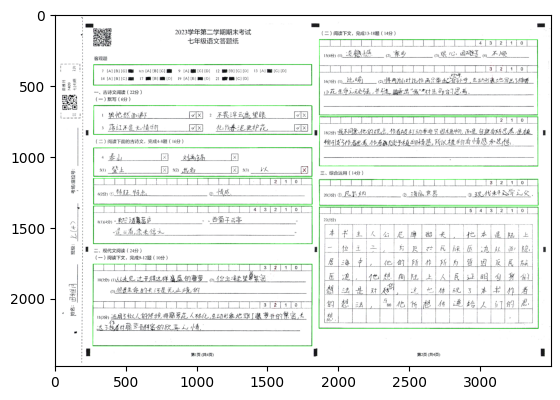

In [8]:
cv2.drawContours(image, answer_cnts, -1, (0, 255, 0), 2)
imshow(image)

In [ ]:
cv2.imwrite('out/paper_res.jpg', image)

In [ ]:
# 自定义轮廓排序算法，对x进行偏移
dis = 20
x_list = []
def findBetterX(_x):
    if len(x_list) == 0:
        x_list.append(_x)
        return _x
    for a in x_list:
        if abs(_x - a) < dis:
            return a
        else:
            continue
    x_list.append(_x)
    return _x

In [ ]:
def get_contour_position(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return findBetterX(x), y

In [ ]:
cnts1 = sorted(answer_cnts, key=get_contour_position, reverse=False)
a = 1
for c in cnts1:
    # arcLength 计算周长
    peri = cv2.arcLength(c, True)
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.imwrite('out/img_'+str(a)+'.jpg', image[y:y + h, x:x + w])
    a = a + 1